# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ast import literal_eval

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [3]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [4]:
# Show the list of column names and the number of rules.

for column in df_rules.columns:
    print(column)

rules = int(df_rules.shape[0])
print(f'\nRules: {rules:,.2f}')

consequent_item
transaction_count
item_set_count
antecedent_count
consequent_count
antecedent_items

Rules: 1,048,575.00


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [5]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

# Calculate support for each rule
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']

# Calculate confidence for each rule
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

# Calculate lift for each rule
df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])

df_rules.head()

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

A high **lift** value indicates that the antecedent, in this case yogurts, has a strong association with the consequent, meaning that the consequent is more likely to occur when the antecedent is present compared to when it is not.

Some reasons why **yogurts** might have a lift value over 9,000:

1. Yogurts are frequently purchased together with certain item
2. High confidence in yogurt-related rules
3. Relatively low baseline support of the consequent
4. Specialty or niche product combinations
5. Promotions or marketing effects
6. Product placement in store


In [6]:
# Query the rule set if you have to to find out more.



## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [7]:
def contains_hummus(items):
    return 'Hummus' in items


one_antecedent_item = df_rules[df_rules['antecedent_items'].apply(lambda x: len(x) == 1)]
lift = one_antecedent_item[(one_antecedent_item['lift'] > 5) & (one_antecedent_item['lift'] < 20)]

lift.loc[:, 'antecedent_items'] = lift['antecedent_items'].apply(lambda x: ', '.join(x))

lift.loc[:, 'antecedent_items'] = lift['antecedent_items'].replace(to_replace=r'.*Hummus.*', value='Hummus', regex=True)
lift.loc[:, 'consequent_item'] = lift['consequent_item'].replace(to_replace=r'.*Hummus.*', value='Hummus', regex=True)

df_rules_subset = lift[
    lift['consequent_item'].apply(contains_hummus) ^ lift['antecedent_items'].apply(contains_hummus)
]

df_rules_subset.head(25)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
377756,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,Hummus,0.000030,0.112740,17.623731
387837,Clementines,3346083,174,1334,32194,Hummus,0.000052,0.130435,13.556738
416420,Hummus,3346083,345,1656,74172,Organic White Pita Bread,0.000103,0.208333,9.398434
419119,Hummus,3346083,293,1434,74172,Organic Whole Wheat Pita,0.000088,0.204324,9.217543
422178,Hummus,3346083,331,1655,74172,Mini Whole Wheat Pita Bread,0.000099,0.200000,9.022496
440198,Hummus,3346083,3119,17333,74172,Sea Salt Pita Chips,0.000932,0.179946,8.117800
442099,Organic Baby Carrots,3346083,258,1334,80493,Hummus,0.000077,0.193403,8.039749
463035,Hummus,3346083,151,933,74172,"Lentil Chips, Himalayan Pink Salt",0.000045,0.161844,7.301163
463988,Hummus,3346083,311,1929,74172,Garbanzo Beans No Salt Added,0.000093,0.161223,7.273189
476420,Hummus,3346083,512,3333,74172,Organic Whole Peeled Baby Carrots,0.000153,0.153615,6.929970


Build a network `graph_rules_subset` from the association rules subset.

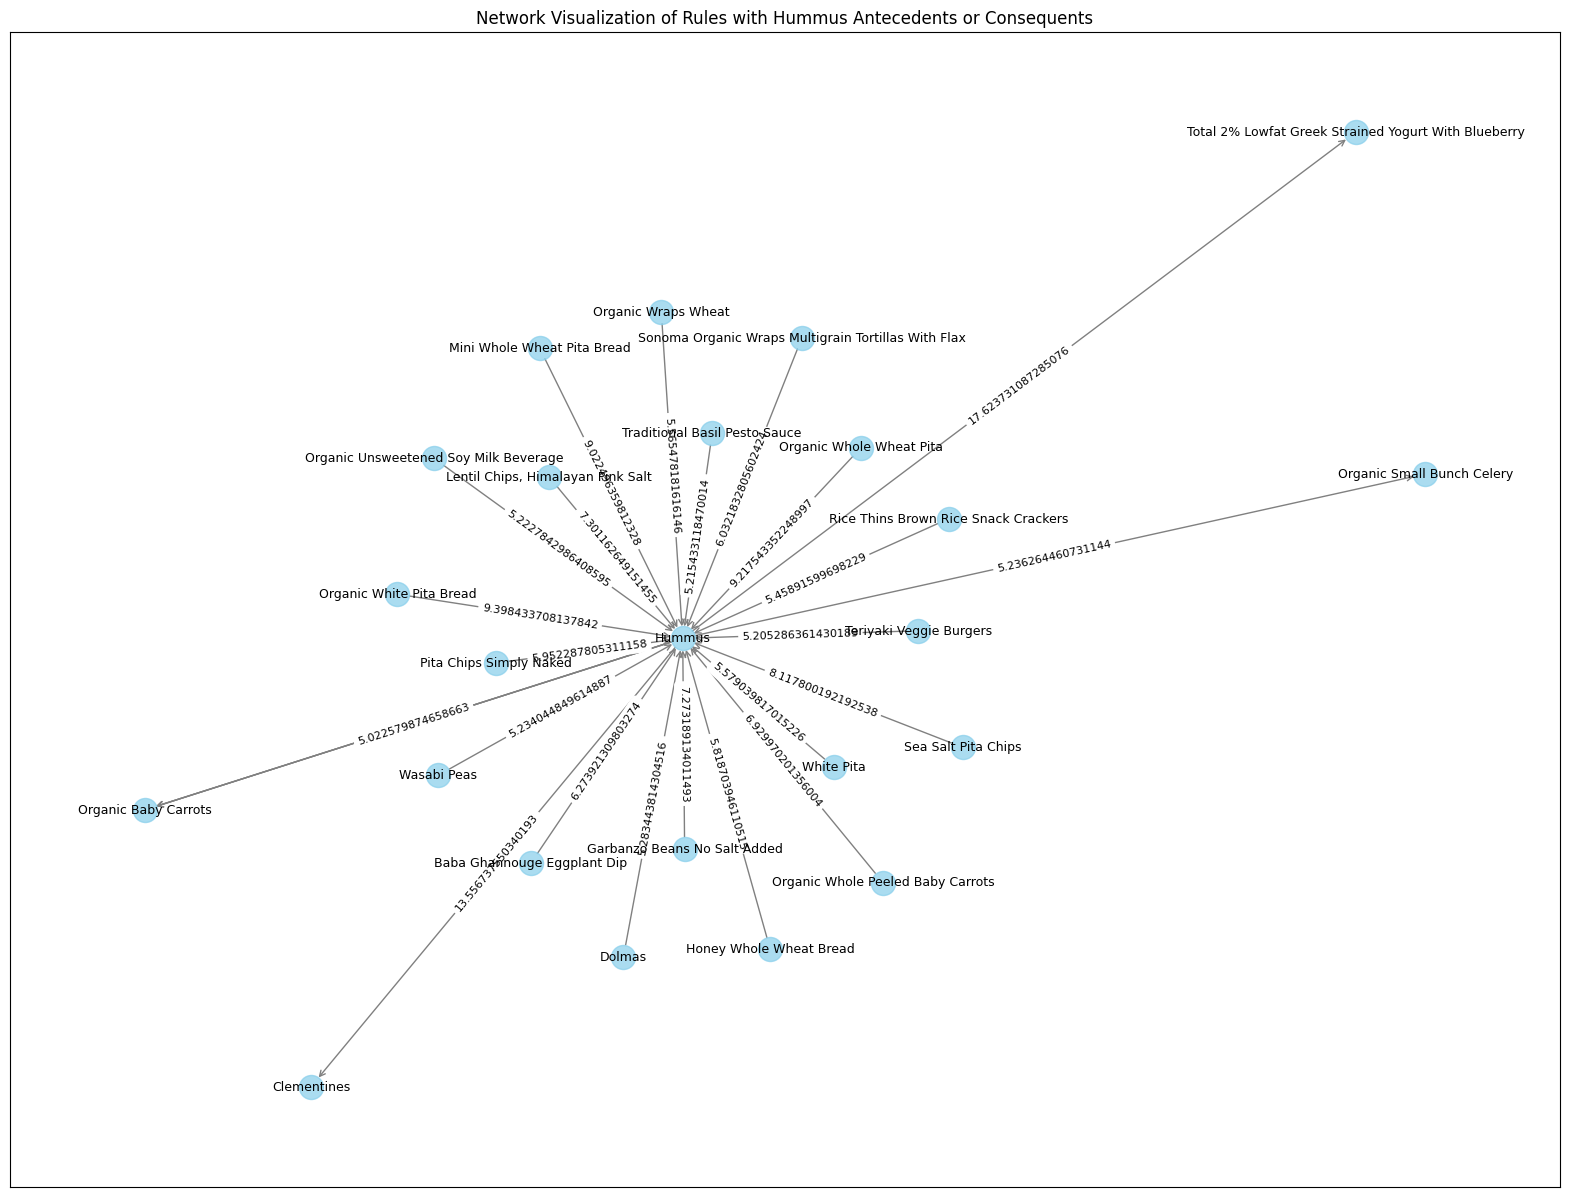

In [8]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()

edges = [
    (row['antecedent_items'], row['consequent_item'], {'lift': row['lift']})
    for _, row in df_rules_subset.iterrows()
]

graph_rules_subset.add_edges_from(edges)

# Then render the graph.

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(graph_rules_subset, k=0.5, seed=42)
nx.draw_networkx_nodes(graph_rules_subset, pos, node_size=300, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(graph_rules_subset, pos, edgelist=graph_rules_subset.edges(), arrowstyle='->', arrowsize=10, edge_color='gray')
nx.draw_networkx_labels(graph_rules_subset, pos, font_size=9, font_family='sans-serif')
edge_labels = nx.get_edge_attributes(graph_rules_subset, 'lift')
nx.draw_networkx_edge_labels(graph_rules_subset, pos, edge_labels=edge_labels, font_size=8)

plt.title('Network Visualization of Rules with Hummus Antecedents or Consequents')
plt.show()

What can you tell about people who buy hummus?

*(Write your answer here.)*

Hummus seems to be associated with the purchase of other foods, most notably various types of wheat products like crackers, pita, pita chips, and wraps. This leads me
to believe that hummus is used as spread or dip, depending on what the item is. It's also associated with the purchase of appetizer-like vegetables, such as 
baby carrots or celery. Which lso ties in to hummus being used as a dip. Hummus could also be associated with a certain type of culture, as many mediterranean 
and middle eastern cultures use hummus in their cuisine. We could also argue that hummus is also associated with more health-conscious shoppers.


## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [9]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

filtered_rules = df_rules[
    df_rules['antecedent_items'].apply(lambda x: any(item in basket for item in x))
]

top_20_consequents = filtered_rules.sort_values('lift', ascending=False).head(20)

top_20_consequents.head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
342462,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,100,209,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Ora...",0.000030,0.478469,80.202217
345882,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,132,311,19962,"[Non Fat Raspberry Yogurt, Orange Bell Pepper]",0.000039,0.424437,71.145298
346832,Nonfat Icelandic Style Strawberry Yogurt,3346083,100,441,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.226757,68.820769
346901,Non Fat Raspberry Yogurt,3346083,184,529,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000055,0.347826,68.651858
349532,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,184,494,19962,"[Non Fat Raspberry Yogurt, Organic Red Bell Pe...",0.000055,0.372470,62.434341
350852,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,167,471,19962,"[Organic Red Bell Pepper, Vanilla Skyr Nonfat ...",0.000050,0.354565,59.433078
350991,Non Fat Raspberry Yogurt,3346083,132,441,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000039,0.299320,59.077960
351360,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,101,291,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Org...",0.000030,0.347079,58.178302
351433,Nonfat Icelandic Style Strawberry Yogurt,3346083,101,529,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.190926,57.946047
351881,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,133,392,19962,"[Orange Bell Pepper, Vanilla Skyr Nonfat Yogurt]",0.000040,0.339286,56.871965


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.

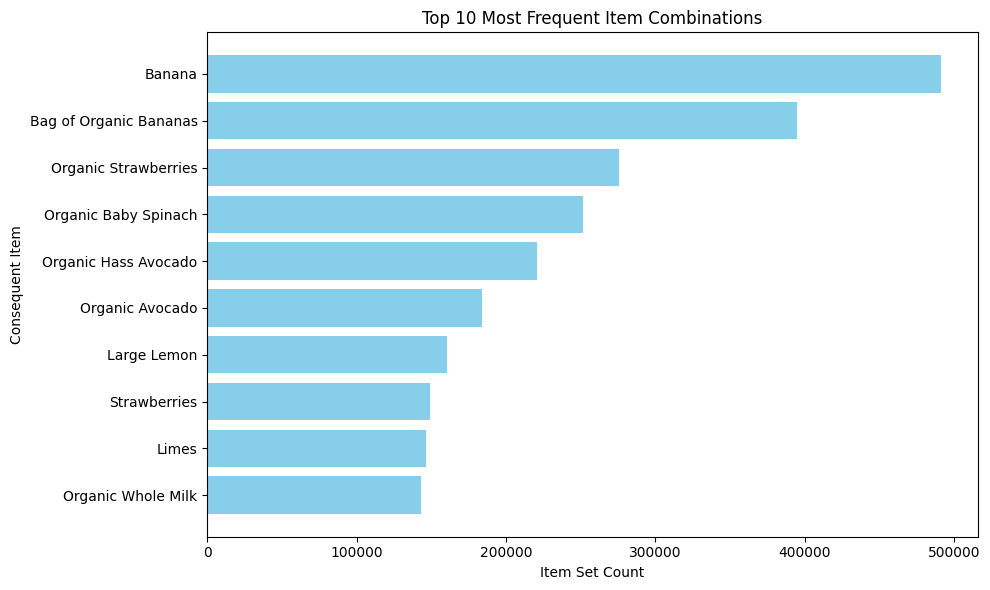

In [10]:
frequent_combinations = df_rules.sort_values(by='item_set_count', ascending=False).head(10)
top_items = frequent_combinations[['consequent_item', 'item_set_count']]

plt.figure(figsize=(10, 6))
plt.barh(top_items['consequent_item'], top_items['item_set_count'], color='skyblue')
plt.xlabel('Item Set Count')
plt.ylabel('Consequent Item')
plt.title('Top 10 Most Frequent Item Combinations')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest count on top
plt.tight_layout()

plt.show()